#### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [3]:
from tqdm import tqdm
from skimage.external import tifffile as sktif

import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from joblib import Parallel, delayed
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [5]:
import solaris as sol
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union

#### Setup

In [4]:
from lovasz_losses import *
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [8]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
train_dir = data_dir / "AOI_3_Paris_Roads_Train"
# small image/mask tiles made in space_net_roads_nvidia.ipynb
rgb_256 = train_dir / "rgb_256"

mask_256 = train_dir / "mask_256"

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/mask_256/mask_256_AOI_3_Paris_img272_0_2.png')]


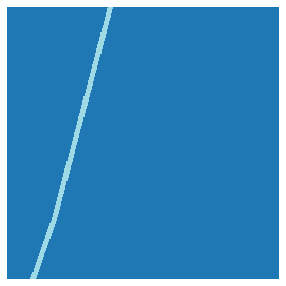

In [19]:
fname = np.random.choice(mask_256.ls(), 1)
print(fname)
mask = open_mask(fname[0])
mask.show(figsize=(5,5), alpha=1)

In [26]:
a = np.array(PIL.Image.open('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/mask_256/mask_256_AOI_3_Paris_img272_0_2.png'))
a.max()

1

In [21]:
mask_with_roads_256 = train_dir / "mask_with_roads_256"
mask_with_roads_256.mkdir(exist_ok=True)

In [27]:
def cp_mask_with_roads(fpath):
    with PIL.Image.open(fpath) as test_image:
        a = np.array(test_image)
        if (a.max() >=1):
            test_image.save(mask_with_roads_256/fpath.name)

In [28]:

%time out = Parallel(n_jobs=28)(delayed(cp_mask_with_roads)(fpath) for fpath in mask_256.ls());

CPU times: user 1.35 s, sys: 214 ms, total: 1.57 s
Wall time: 3.96 s


In [29]:
len(mask_with_roads_256.ls())

3420

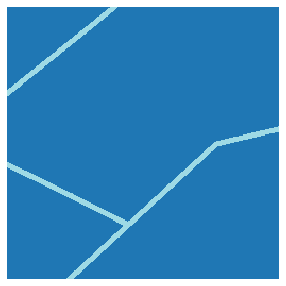

In [31]:
fname = np.random.choice(mask_with_roads_256.ls(), 1)

mask = open_mask(fname[0])
mask.show(figsize=(5,5), alpha=1)

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2., logits=False, reduction='elementwise_mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)